Bphi: [[0.1 0.1]
 [0.9 0.9]]
v_old: [-1.60000000e+01  1.12535168e-07]
v_new: [-18.62766672  -2.18822189]
PS[:,1]: [0.49864454 0.50135546]
PS[:,2]: [0.52404079 0.47595921]
PS[:,3]: [0.60316548 0.39683452]
PS[:,4]: [0.65673503 0.34326497]
PS[:,5]: [0.71027301 0.28972699]
PS[:,6]: [0.75614866 0.24385134]
PS[:,7]: [0.80370001 0.19629999]
PS[:,8]: [0.83218688 0.16781312]
PS[:,9]: [0.86558271 0.13441729]
PS[:,10]: [0.88529918 0.11470082]
PS[:,11]: [0.90840184 0.09159816]
PS[:,12]: [0.92114903 0.07885097]
PS[:,13]: [0.93107363 0.06892637]
PS[:,14]: [0.94379357 0.05620643]
PS[:,15]: [0.9531673 0.0468327]
PS[:,16]: [0.95951041 0.04048959]
PS[:,17]: [0.9641964 0.0358036]
PS[:,18]: [0.96963023 0.03036977]
PS[:,19]: [0.9728569 0.0271431]
PS[:,20]: [0.9753739 0.0246261]
PS[:,21]: [0.97901948 0.02098052]
PS[:,22]: [0.98070507 0.01929493]
PS[:,23]: [0.98366221 0.01633779]
PS[:,24]: [0.98600806 0.01399194]
PS[:,25]: [0.98812735 0.01187265]
PS[:,26]: [0.98888054 0.01111946]
PS[:,27]: [0.98974656 0.0102

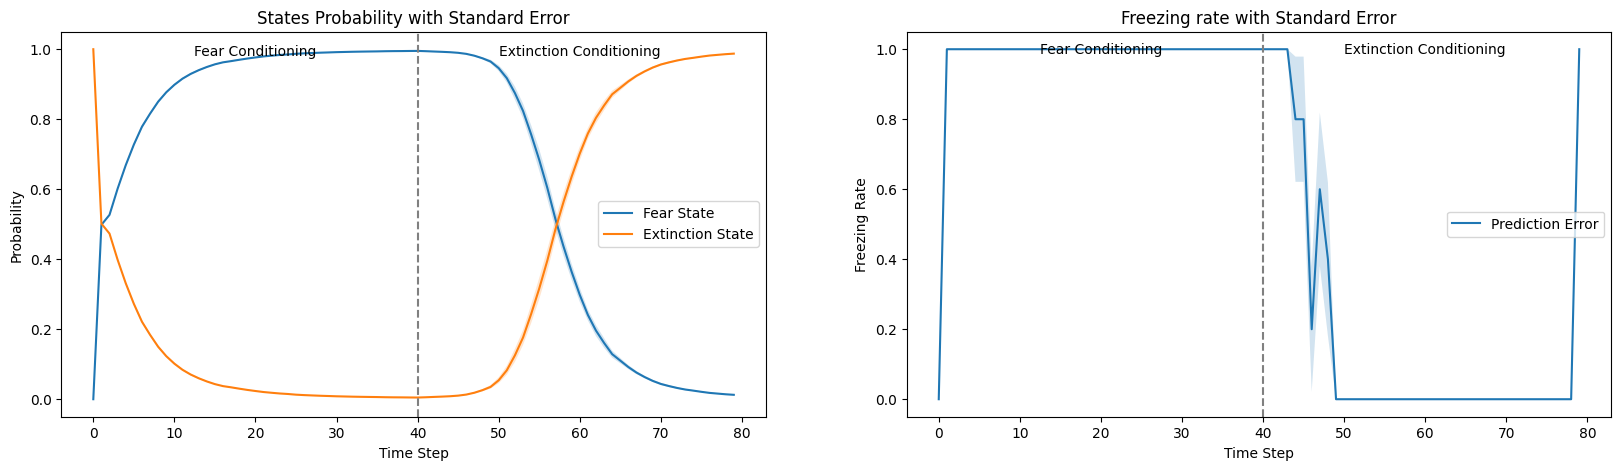

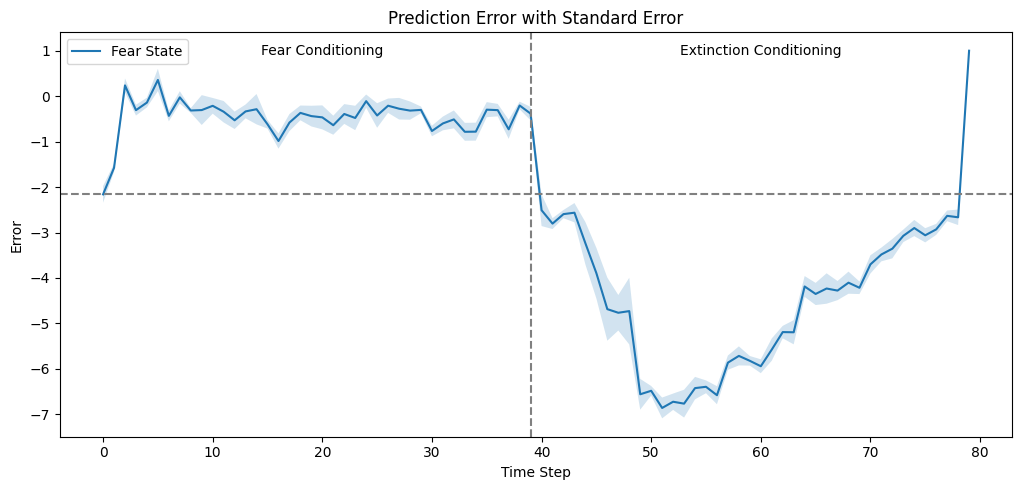

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Chose simulation type
#=================================================
# Type
#-------------------------------------------------
TYPE = 1 # shock終了時まではfreezing，その後はnot freezing。確率はsigmoid関数にしたがう
#TYPE = 2 # 特にfreezingは考慮しない。scale_factor割の確率で前の状態にとどまる（e.g fear to fear / extinction to extinction）
#TYPE = 3 # freezingしない

scale_factor = 9

# Injections
#-------------------------------------------------
Injections = False # If true, prediction error reduce for initial 2 seconds in extinction conditioning

# simulation parameters
#=================================================
# for simulation
#-------------------------------------------------
dt   = 0.5 # time window (sec)
t_f  = 20  # time for fear conditioning (sec)
t_e  = 20  # time for extinction conditioning (sec)
t_s  = 2   # time for shock (sec)

Nf   = len(np.arange(0, t_f, dt))       # time steps for fear state
Ne   = len(np.arange(0, t_e, dt))       # time steps for extinction state
N    = len(np.arange(0, t_f + t_e, dt)) # time steps

# for generative model
#-------------------------------------------------
Ns = 2  # number of states (fear, extinction)
No = 2  # number of observations (shock/sound, no shock/sound)
Nu = 2  # number of control variables (freezing, not freezing)

# for gradient descent
#-------------------------------------------------
It = 5   # number of task iterations
Ni = 1   # number of iterations for gradient descent
k  = 0.05 # learning rate
reduce_rate = 0.01 # if injection is true, then k reduce to k * reduce_rate

# generative model
#=================================================
# Generative Model Parameters

# function
#-------------------------------------------------
def probabilistic_select(P,n):
    return np.random.choice(range(len(P[:, n])), p = P[:, n])

# initialise belief states (S)
#-------------------------------------------------
PS = np.ones((Ns, N)) / Ns # probability of state
S  = np.zeros(N)             # chosen state

# Initialise observations (O)
#-------------------------------------------------
PO = np.ones((No, N)) / No # probability of observation
O  = np.zeros(N)            # chosen observation

# Initialise the control variable (U)
#-------------------------------------------------
PU = np.ones((Nu,N)) / Nu
U = np.zeros(N)


# parameters
#=================================================
# function
#-------------------------------------------------


# Likelihood (A)
#-------------------------------------------------
A = np.array([
    # fear, extinction: S_t
    [0.9, 0.1],               # shock    (O_t)
    [0.1, 0.9]                # no shock (O_t)
])

# Transition probability (B)
#-------------------------------------------------
# Not working currently because of scaling issue when using softmax function. Need to fix
#-------------------------------------------------
# B
#B_base = np.array([
#    # fear, extinction: S_t
#    [1, 1],                 # fear       (S_t+1)
#    [1, 1]                  # extinction (S_t+1)
#])
#
#def scale_B(scale_factor, U, B=B_base, type=TYPE):
#    if type == 1:
#        B[0, :] = B[0, :] * scale_factor if U == 0 else B[0, :] # freezing
#        B[1, :] = B[1, :] * scale_factor if U == 1 else B[1, :] # not freezing
#    if type == 2:
#        B[0, 0] = B[0, 0] * scale_factor
#        B[1, 1] = B[1, 1] * scale_factor
#    if type == 3:
#        B[1, :] = B[1, :] * scale_factor
#    return softmax(B)
#

# It's alternative way
#-------------------------------------------------
# B_freezing
B_f = np.array([
    # fear, extinction: S_t
    [0.9, 0.9],             # fear       (S_t+1)
    [0.1, 0.1]              # extinction (S_t+1)
])

# B_not_freezing
B_nf = np.array([
    # fear, extinction: S_t
    [0.1, 0.1],             # fear       (S_t+1)
    [0.9, 0.9]              # extinction (S_t+1)
])

# B_general
B_g = np.array([
    # fear, extinction: S_t
    [0.9, 0.1],             # fear       (S_t+1)
    [0.1, 0.9]              # extinction (S_t+1)
])

def choice_B(U):
    if TYPE == 1:
        return B_f if U == 0 else B_nf
    if TYPE == 2:
        return B_g
    if TYPE == 3:
        return B_nf

# Initial state probability (D)
#-------------------------------------------------
D = [0,1] # fear, extinction: S_0

# Preference for Polycy U (E)
#-------------------------------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def freezing_probability(x, delay):
    return 1 - sigmoid(x - delay)

def calculate_PU(n, delay_time = t_f + t_s, dt = dt):
    delay = (delay_time + np.random.normal(1, 1)) / dt
    freezing     = freezing_probability(n, delay)
    not_freezing = 1 - freezing
    return np.array([[freezing, not_freezing]])


# message passing
#====================================================================================================
# function
#-------------------------------------------------
def ln(x):
    return np.log(x + np.exp(-16))

def dot(A, B):
    return np.dot(A, B.T)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# message passing
#-------------------------------------------------
# Initialise storages
all_PS = np.zeros((It, Ns, N))
all_e  = np.zeros((It, Ns, N))
all_U  = np.zeros((It, Ns, N))
Lss    = np.zeros(It) # likelihood of sound to shock

for it in range(It):
    # generative process
    #=================================================
    # Params for generative process
    Lss0  = 0.9 # initial likelihood of sound to shock
    Lss[it] = Lss0 - np.random.normal(0, 0.005, 1) * it # ith likelihood: constant decrease

    # Initialise generative process
    #observations_s = np.tile(np.array([1, 0]), (Nf, 1)) # [shock, no shock] times Nf
    observations_s = np.tile(np.array([Lss[it], 1 - Lss[it]]), (Nf, 1)) # [shock, no shock] times Nf
    observations_n = np.tile(np.array([0, 1]), (Ne, 1)) # [shock, no shock] times Ne
    observations   = np.concatenate((observations_s, observations_n), axis=0) # [shock, no shock] times (Nf + Ne)

    # Noise in the generative process


    # Initialise Message
    #=================================================
    lnAo        = np.ones((No, N)) / No # 8 times 1000
    lnBs_past   = np.ones((Ns, N)) / Ns # 8 times 1000
    lnBs_future = np.ones((Ns, N)) / Ns # 8 times 1000
    v = np.ones((Ns, N)) # prediction
    e = np.ones((Ns, N)) # prediction error
    
    K = np.repeat(k, N) # learning rate
    if Injections:
        K[int(t_f / dt) : int((t_f + t_s) / dt)] = K[int(t_f / dt) : int((t_f + t_s) / dt)] * reduce_rate # if injection is true, then k reduce to k * reduce_rate
   
    # n = 0
    #-------------------------------------------------
    for _ in range(Ni):

        PS[:,0] = D
        S[0]    = probabilistic_select(PS,0)

        PO[:,0] = observations[0]
        O[0]    = probabilistic_select(PO,0)
        #print("PO[:,0]:", PO[:,0])
        #print("O[0]:", O[0])

        #PU[:,0] = calculate_PU(0)
        PU[:,0] = np.array([0, 1])
        U[0]    = probabilistic_select(PU,0)

        # message
        #-------------------------------------------------
        # lnAo
        lnAo[:,0] = dot(ln(A), PO[:,0]) # need to fix: Actual observation
        #print('lnAo[:,0]:', lnAo[:,0])

        # lnBs_past
        Bphi           = D
        lnBs_past[:,0] = ln(Bphi) #dot(ln(Bphi), PS[:,0])
        #print('Bphi:', Bphi)
        #print('lnBs_past[:,0]:', lnBs_past[:,0])

        # lnBs_future
        Bphi             = choice_B(U[0])
        #Bphi             = scale_B(scale_factor, U[0])
        lnBs_future[:,0] = dot(ln(Bphi), PS[:,1])
        print('Bphi:', Bphi)
        #print('lnBs_future[:,0]:', lnBs_future[:,0])

        # noise
        noise = np.random.normal(0, 0.5, 2)
        
        # Belief update
        #-------------------------------------------------
        v_old = ln(D)
        print('v_old:', v_old)
        v_new = lnAo[:,0] + lnBs_past[:,0] + lnBs_future[:,0]
        print('v_new:', v_new)
        e[:,0] = v_new - v_old + noise
        v[:,0] = v[:,0] + K[0] * e[:,0]

        PS[:,1] = softmax(v[:,0])
    
    #print('v:', v[:,0])
    #print('e:', e[:,0])
    print('PS[:,1]:', PS[:,1])

    # n = 1 ~
    #-------------------------------------------------
    for n in range(1, N-1):
        for _ in range(Ni):
            # probability and value
            #-------------------------------------------------
            S[n]    = probabilistic_select(PS,n)

            PO[:,n] = observations[n]
            O[n]    = probabilistic_select(PO,n)

            PU[:,n] = calculate_PU(n)
            #PU[:,n] = np.array([1, 0])
            U[n]    = probabilistic_select(PU,n)

            # message
            #-------------------------------------------------
            # lnAo
            lnAo[:,n] = dot(ln(A), PO[:,n]) # need to fix
            #print('lnAo[:,{}]:'.format(n), lnAo[:,n])

            # lnBs_past
            Bphi           = choice_B(U[n-1])
            #Bphi           = scale_B(scale_factor, U[n-1], B_base)
            lnBs_past[:,n] = np.dot(ln(Bphi), PS[:,n])
            #print('Bphi:', Bphi)
            #print('ln(Bphi):', ln(Bphi))
            #print('PS[:,{}]:'.format(n), PS[:,n])
            #print('lnBs_past[:,{}]:'.format(n), lnBs_past[:,n])

            # lnBs_future
            Bphi             = choice_B(U[n])
            #Bphi             = scale_B(scale_factor, U[n+1], B_base)
            lnBs_future[:,n] = dot(ln(Bphi), PS[:,n+1])
            #print('lnBs_future[:,{}]:'.format(n), lnBs_future[:,n])

            # noise
            noise = np.random.normal(0, 0.5, 2)

            # Belief update
            #-------------------------------------------------
            v_old = ln(PS[:,n])
            v_new = lnAo[:,n] + lnBs_past[:,n] + lnBs_future[:,n]
            e[:,n] = v_new - v_old + noise
            v[:,n] = v[:,n-1] + K[n] * e[:,n]
            #print('v_old:', v_old)
            #print('v_new:', v_new)
            #print('v[:,{}]:'.format(n), v[:,n])
            #print('e[:,{}]:'.format(n), e[:,n])
            
            PS[:,n+1] = softmax(v[:,n])

        print('PS[:,{}]:'.format(n+1), PS[:,n+1])

    # store results
    all_PS[it] = PS
    all_e[it]  = e
    all_U[it]  = U


# for plotting
#=================================================
# difference of e
#all_e_diff = np.zeros((It, Ns, N-1))
#for it in range(It):
#    all_e_diff[it] = np.diff(all_e[it], axis=1)

# mean and standard error 
mean_PS   = np.mean(all_PS, axis=0)
stderr_PS = np.std(all_PS, axis=0) / np.sqrt(It)
mean_e    = np.mean(all_e, axis=0)
#mean_e    = np.mean(all_e_diff, axis=0)
stderr_e  = np.std(all_e, axis=0) / np.sqrt(It)
#stderr_e  = np.std(all_e_diff, axis=0) / np.sqrt(It)
mean_U    = 1 - np.mean(all_U, axis=0)
stderr_U  = np.std(all_U, axis=0) / np.sqrt(It)

# index
state_index = ['Fear State', 'Extinction State']

# ploting
plt.figure(figsize=(20, 5))

# PS
plt.subplot(1, 2, 1)
for state in range(Ns):
    plt.plot(np.arange(N), mean_PS[state, :], label=state_index[state])
    plt.fill_between(np.arange(N), mean_PS[state, :] - stderr_PS[state, :], mean_PS[state, :] + stderr_PS[state, :], alpha=0.2)
plt.axvline(x=N/2, color='gray', linestyle='--')  # 真ん中に点線を追加
plt.text(N/4, max(mean_PS[0, :]), 'Fear Conditioning', horizontalalignment='center', verticalalignment='center')  # 点線より左に文字を追加
plt.text(3*N/4, max(mean_PS[0, :]), 'Extinction Conditioning', horizontalalignment='center', verticalalignment='center')  # 点線より左に文字を追加
plt.title('States Probability with Standard Error')
plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.legend()

# U
if TYPE == 1:
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(N), mean_U[0, :], label=f'Prediction Error')
    plt.fill_between(np.arange(N), mean_U[0, :] - stderr_U[0, :], mean_U[0, :] + stderr_U[0, :], alpha=0.2)
    plt.axvline(x=N/2, color='gray', linestyle='--')  # 真ん中に点線を追加
    plt.text(N/4, max(mean_U[0, :]), 'Fear Conditioning', horizontalalignment='center', verticalalignment='center')  # 点線より左に文字を追加
    plt.text(3*N/4, max(mean_U[0, :]), 'Extinction Conditioning', horizontalalignment='center', verticalalignment='center')  # 点線より左に文字を追加
    plt.title('Freezing rate with Standard Error')
    plt.xlabel('Time Step')
    plt.ylabel('Freezing Rate')
    plt.legend()

# e
state = 0
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
#for state in range(Ns):
#    plt.plot(np.arange(np.size(mean_e, 1)), mean_e[state, :], label=state_index[state])
#    plt.fill_between(np.arange(np.size(mean_e, 1)), mean_e[state, :] - stderr_e[state, :], mean_e[state, :] + stderr_e[state, :], alpha=0.2)
plt.plot(np.arange(np.size(mean_e, 1)), mean_e[state, :], label=state_index[state])
plt.fill_between(np.arange(np.size(mean_e, 1)), mean_e[state, :] - stderr_e[state, :], mean_e[state, :] + stderr_e[state, :], alpha=0.2)
plt.axvline(x=N/2-1, color='gray', linestyle='--')  # 真ん中に垂線を追加
plt.axhline(y=mean_e[0, 0], color='grey', linestyle='--')  # y=0に横線を追加
plt.text(N/4, max(mean_e[0, :]), 'Fear Conditioning', horizontalalignment='center', verticalalignment='center')  # 点線より左に文字を追加
plt.text(3*N/4, max(mean_e[0, :]), 'Extinction Conditioning', horizontalalignment='center', verticalalignment='center')  # 点線より左に文字を追加
plt.title('Prediction Error with Standard Error')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()